In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta, datetime
from scipy import stats as st
%matplotlib inline
from fbprophet import Prophet
from pmdarima.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

class color:
    BOLD = '\033[1m'
    END = '\033[0m'

df = pd.read_csv (r"...\Demand Forecasting Data Story Pivot.csv", parse_dates=['Week_Start'], low_memory=False, skipinitialspace=True)
#df.index.names = ['ds']
df = df.rename({'Week_Start': 'ds'}, axis=1)

print(df.head())
print(df.info())

          ds          17          46         54        111          201   424  \
0 2018-07-01  164.285714  306.382979  23.971429  14.605714  1833.333333   0.0   
1 2018-07-08  400.000000  405.263158  41.581197  14.506410  2071.428571   0.0   
2 2018-07-15  127.777778  267.857143  75.186916  14.125683  2166.666667   6.0   
3 2018-07-22  157.894737  304.000000  53.584158  12.157895  2611.111111  10.0   
4 2018-07-29  191.304348  265.517241  70.456522  18.466321  3000.000000   0.0   

          561        566        574  ...     121302      124669      124670  \
0  141.666667  42.403670  70.560000  ...  64.880952  145.714286   97.560976   
1  300.000000  31.111111  70.000000  ...  67.647059  164.285714   81.578947   
2  244.444444  39.909091  62.666667  ...  65.060241  166.666667  112.222222   
3  205.263158  44.587156  62.181818  ...  60.294118  161.290323  105.555556   
4  180.555556  37.019231  64.000000  ...  62.126316  150.000000   94.565217   

        125900      129090     129751 

In [2]:
start_date = min(df['ds'])
end_date = max(df['ds'])

print(start_date, end_date)

2018-07-01 00:00:00 2020-06-28 00:00:00


In [3]:
days = pd.to_datetime(end_date) - pd.to_datetime(start_date)
week = int(pd.Timedelta(days).days / 7)

print(week, ' weeks')

104  weeks


In [4]:
train_len = int(week * 0.99)

print(train_len)

102


## A subset of the data will be fitted before the entire set is done. First, a Prophet model will be used on Item 17.

In [5]:
df17 = df[['ds','17']]
print(df17)

            ds          17
0   2018-07-01  164.285714
1   2018-07-08  400.000000
2   2018-07-15  127.777778
3   2018-07-22  157.894737
4   2018-07-29  191.304348
..         ...         ...
100 2020-05-31  176.923077
101 2020-06-07  233.333333
102 2020-06-14  338.888889
103 2020-06-21  188.235294
104 2020-06-28  100.000000

[105 rows x 2 columns]


# Prophet expects a dataframe of 2 columns labeled 'ds' and 'y'. Therefore, '17' is renamed to 'y'.

In [6]:
df17 = df17.rename({'17': 'y'}, axis=1)
print(df17)

            ds           y
0   2018-07-01  164.285714
1   2018-07-08  400.000000
2   2018-07-15  127.777778
3   2018-07-22  157.894737
4   2018-07-29  191.304348
..         ...         ...
100 2020-05-31  176.923077
101 2020-06-07  233.333333
102 2020-06-14  338.888889
103 2020-06-21  188.235294
104 2020-06-28  100.000000

[105 rows x 2 columns]


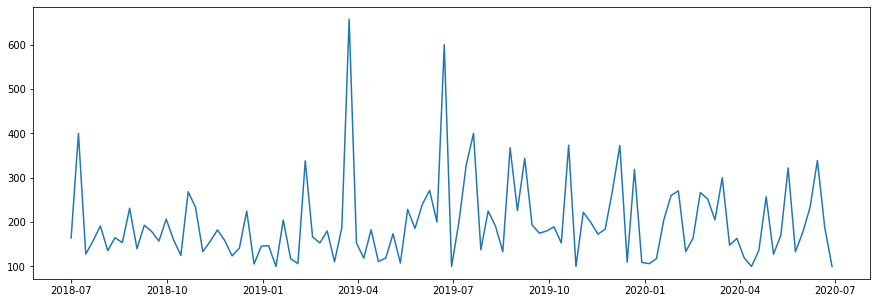

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df17['ds'],df17['y'])

(array([38., 36., 13.,  7.,  7.,  2.,  0.,  0.,  1.,  1.]),
 array([100.        , 155.71428571, 211.42857143, 267.14285714,
        322.85714286, 378.57142857, 434.28571429, 490.        ,
        545.71428571, 601.42857143, 657.14285714]),
 <a list of 10 Patch objects>)

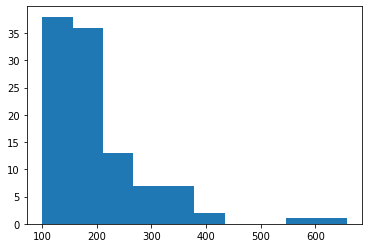

In [8]:
plt.hist(df17['y'])

In [9]:
y_train17, y_test17 = train_test_split(df17, train_size=train_len)
print(y_train17)

            ds           y
0   2018-07-01  164.285714
1   2018-07-08  400.000000
2   2018-07-15  127.777778
3   2018-07-22  157.894737
4   2018-07-29  191.304348
..         ...         ...
97  2020-05-10  170.000000
98  2020-05-17  322.222222
99  2020-05-24  133.333333
100 2020-05-31  176.923077
101 2020-06-07  233.333333

[102 rows x 2 columns]


In [10]:
print(y_test17)

            ds           y
102 2020-06-14  338.888889
103 2020-06-21  188.235294
104 2020-06-28  100.000000


# As was discovered in the basic model, item 17's data is skewed. Therefore, it needs to be transformed. A box cox transformation was found to be the best for this data.

C:\Users\82643\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(array([12.,  7., 11., 13., 19., 14., 13.,  6.,  5.,  2.]),
 array([1.35526663, 1.35921933, 1.36317202, 1.36712471, 1.37107741,
        1.3750301 , 1.3789828 , 1.38293549, 1.38688818, 1.39084088,
        1.39479357]),
 <a list of 10 Patch objects>)

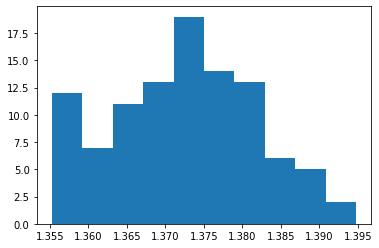

In [11]:
#Transform using box cox
#https://mode.com/example-gallery/forecasting_prophet_python_cookbook/

y_train17['y'], lam = boxcox(y_train17['y'])

plt.hist(y_train17['y'])

In [12]:
print(y_train17)

            ds         y
0   2018-07-01  1.371190
1   2018-07-08  1.388841
2   2018-07-15  1.363829
3   2018-07-22  1.370113
4   2018-07-29  1.375051
..         ...       ...
97  2020-05-10  1.372094
98  2020-05-17  1.385516
99  2020-05-24  1.365170
100 2020-05-31  1.373121
101 2020-06-07  1.379500

[102 rows x 2 columns]


# The data is fit to the Prophet model and a forecast is calculated.

In [13]:
m = Prophet()
m.fit(y_train17)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=5, freq='W')
future.tail()



,ds
102,2020-06-14
103,2020-06-21
104,2020-06-28
105,2020-07-05
106,2020-07-12


In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
102,2020-06-14,1.371339,1.360144,1.383526
103,2020-06-21,1.371235,1.360341,1.382613
104,2020-06-28,1.371131,1.360029,1.382334
105,2020-07-05,1.371028,1.359613,1.382569
106,2020-07-12,1.370924,1.359441,1.382507


# The forecast is transformed back using inverse box cox so that it can be compared with the test data.

In [16]:
#Transform back using inverse box cox
#https://mode.com/example-gallery/forecasting_prophet_python_cookbook/

# Apply inverse Box-Cox transform to specific forecast columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
102,2020-06-14,165.206126,114.382705,287.172937
103,2020-06-21,164.564483,115.035845,273.210700
104,2020-06-28,163.927090,114.000920,269.183597
105,2020-07-05,163.293906,112.649500,272.574837
106,2020-07-12,162.664892,112.096261,271.668312


In [17]:
print(forecast.head())

          ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2018-07-01  1.373367  117.967041  303.494125     1.373367     1.373367   
1 2018-07-08  1.373196  118.629053  310.498211     1.373196     1.373196   
2 2018-07-15  1.373025  116.001463  292.672437     1.373025     1.373025   
3 2018-07-22  1.372854  118.508281  285.173262     1.372854     1.372854   
4 2018-07-29  1.372683  118.109311  285.026004     1.372683     1.372683   

   additive_terms  additive_terms_lower  additive_terms_upper  \
0             0.0                   0.0                   0.0   
1             0.0                   0.0                   0.0   
2             0.0                   0.0                   0.0   
3             0.0                   0.0                   0.0   
4             0.0                   0.0                   0.0   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                   

# The forecast is plotted.

In [18]:
df17_ds_index = df17.set_index('ds')
y_train17_ds_index = y_train17.set_index('ds')
y_train17_ds_index = y_train17_ds_index.apply(lambda x: inv_boxcox(x, lam))
y_test17_ds_index = y_test17.set_index('ds')
forecast_ds_index = forecast.set_index('ds')
print('df17',df17_ds_index)
print('y-train',y_train17_ds_index.head())
print('y-test',y_test17_ds_index.head())
print('forecast',forecast_ds_index.head())

df17                      y
ds                    
2018-07-01  164.285714
2018-07-08  400.000000
2018-07-15  127.777778
2018-07-22  157.894737
2018-07-29  191.304348
...                ...
2020-05-31  176.923077
2020-06-07  233.333333
2020-06-14  338.888889
2020-06-21  188.235294
2020-06-28  100.000000

[105 rows x 1 columns]
y-train                      y
ds                    
2018-07-01  164.285714
2018-07-08  400.000000
2018-07-15  127.777778
2018-07-22  157.894737
2018-07-29  191.304348
y-test                      y
ds                    
2020-06-14  338.888889
2020-06-21  188.235294
2020-06-28  100.000000
forecast                trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
ds                                                                       
2018-07-01  1.373367  117.967041  303.494125     1.373367     1.373367   
2018-07-08  1.373196  118.629053  310.498211     1.373196     1.373196   
2018-07-15  1.373025  116.001463  292.672437     1.373025     1.373025   
20

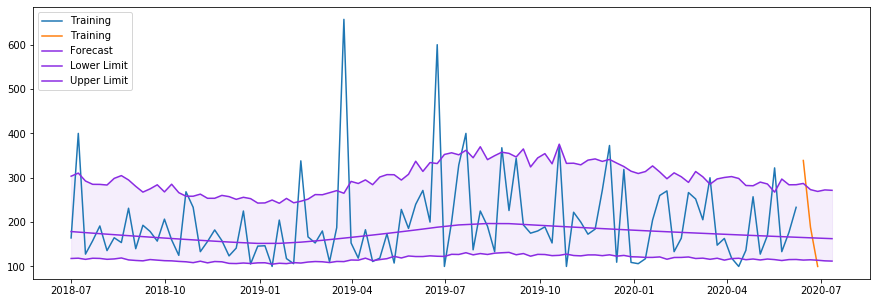

In [19]:
#Plot training, test, forecast
#https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5

plt.figure(figsize=(15,5))
plt.plot(y_train17_ds_index,label='Training')
plt.plot(y_test17_ds_index,label='Training')
plt.plot(forecast_ds_index['yhat'],label='Forecast',color='blueviolet')
plt.plot(forecast_ds_index['yhat_lower'],label='Lower Limit', color='blueviolet')
plt.plot(forecast_ds_index['yhat_upper'],label='Upper Limit', color='blueviolet')
plt.fill_between(forecast.ds, forecast['yhat_lower'], forecast['yhat_upper'],color='blueviolet', alpha=0.08)
plt.legend(loc='upper left')
plt.show()


In [20]:
# Transform y back to reality from Box Cox
y_train17[['y']] = y_train17[['y']].apply(lambda x: inv_boxcox(x, lam))
y_train17.head()

C:\Users\82643\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,ds,y
0,2018-07-01,164.285714
1,2018-07-08,400.000000
2,2018-07-15,127.777778
3,2018-07-22,157.894737
4,2018-07-29,191.304348


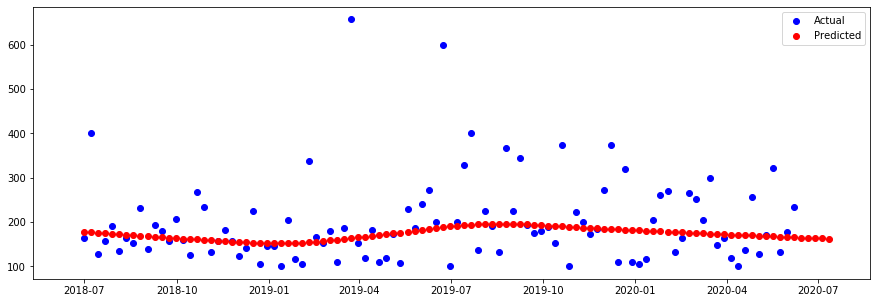

In [21]:
# Plot the results
plt.figure(figsize=(15,5))
label=['Actual','Predicted']
plt.scatter(x=y_train17['ds'], y=y_train17['y'],c='blue', label = 'Actual')
plt.scatter(x=forecast['ds'], y=forecast['yhat'], c='red', label = 'Predicted')
plt.legend(label)
plt.show()

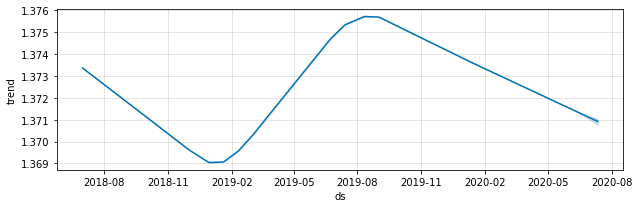

In [22]:
fig2 = m.plot_components(forecast)


# The forecast is evaluated using cross validation.

In [23]:
# https://futurice.com/blog/business-forecasting-with-facebook-prophet
#Training data (initial): The amount of data set aside for training. The parameter is in the API called initial.
#Horizon: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2.
#Cutoff (period): a forecast is made for every observed point between cutoff and cutoff + horizon.

df17_cv = cross_validation(m, initial= '99 W', period='1 W', horizon = '2 W')
df17_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-05-24 00:00:00 and 2020-05-24 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-31,1.370580,1.359739,1.382424,1.373121,2020-05-24
1,2020-06-07,1.370441,1.359067,1.382244,1.379500,2020-05-24


In [24]:
# https://futurice.com/blog/business-forecasting-with-facebook-prophet
df17_p = performance_metrics(df17_cv)
df17_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,0.000006,0.002542,0.002542,0.001851,0.001851,1.0
1,14 days,0.000082,0.009059,0.009059,0.006567,0.006567,1.0


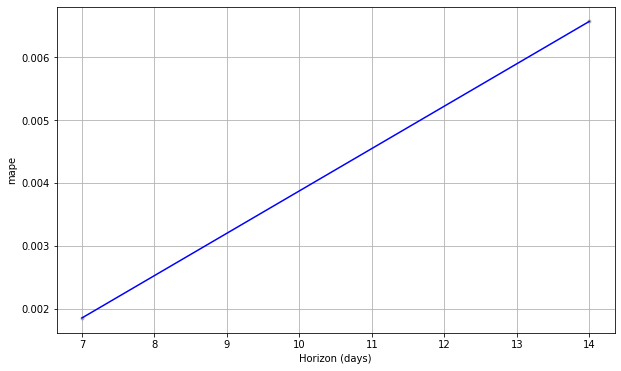

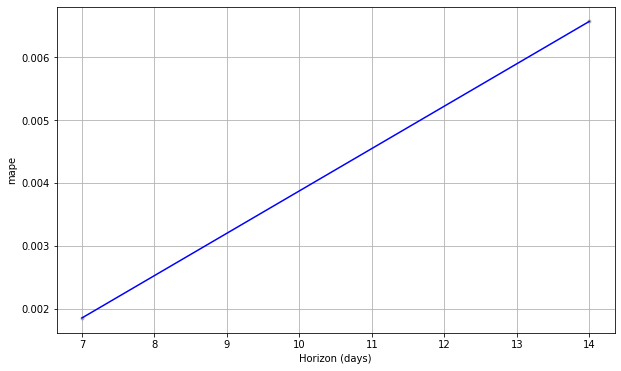

In [25]:
#https://futurice.com/blog/business-forecasting-with-facebook-prophet
#mape = mean absolute percentage error

plot_cross_validation_metric(df17_cv, metric='mape')

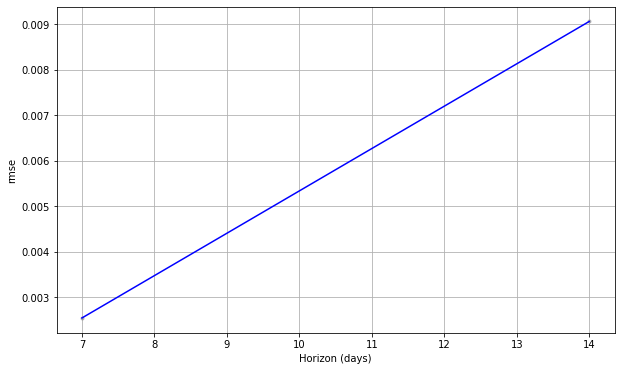

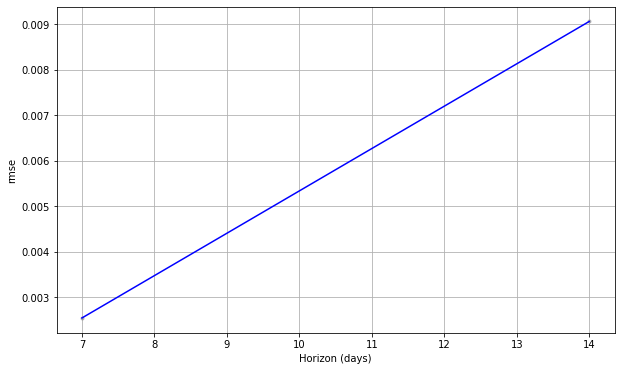

In [26]:
#rmse is mean squared error
plot_cross_validation_metric(df17_cv, metric='rmse')

In [27]:
#find r squared and mean absolute error

from sklearn.metrics import r2_score
print("r2_score",r2_score(y_test17.y,forecast.yhat[102:105]))


from sklearn.metrics import mean_absolute_error
mae2 = mean_absolute_error(y_test17.y,forecast.yhat[102:105])
print('MAE: %f' % mae2)

r2_score -0.19289774080724564
MAE: 87.093555


In [28]:
#https://github.com/facebook/prophet/issues/309
df17_merge = pd.merge(df17, forecast, on='ds')

print(df17_merge.head())

          ds           y     trend  yhat_lower  yhat_upper  trend_lower  \
0 2018-07-01  164.285714  1.373367  117.967041  303.494125     1.373367   
1 2018-07-08  400.000000  1.373196  118.629053  310.498211     1.373196   
2 2018-07-15  127.777778  1.373025  116.001463  292.672437     1.373025   
3 2018-07-22  157.894737  1.372854  118.508281  285.173262     1.372854   
4 2018-07-29  191.304348  1.372683  118.109311  285.026004     1.372683   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     1.373367             0.0                   0.0                   0.0   
1     1.373196             0.0                   0.0                   0.0   
2     1.373025             0.0                   0.0                   0.0   
3     1.372854             0.0                   0.0                   0.0   
4     1.372683             0.0                   0.0                   0.0   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0  

In [29]:
df17_merge['residuals'] = df17_merge['yhat'] - df17_merge['y']
print(df17_merge)

            ds           y     trend  yhat_lower  yhat_upper  trend_lower  \
0   2018-07-01  164.285714  1.373367  117.967041  303.494125     1.373367   
1   2018-07-08  400.000000  1.373196  118.629053  310.498211     1.373196   
2   2018-07-15  127.777778  1.373025  116.001463  292.672437     1.373025   
3   2018-07-22  157.894737  1.372854  118.508281  285.173262     1.372854   
4   2018-07-29  191.304348  1.372683  118.109311  285.026004     1.372683   
..         ...         ...       ...         ...         ...          ...   
100 2020-05-31  176.923077  1.371547  115.506886  284.148555     1.371547   
101 2020-06-07  233.333333  1.371443  115.734936  284.326680     1.371443   
102 2020-06-14  338.888889  1.371339  114.382705  287.172937     1.371337   
103 2020-06-21  188.235294  1.371235  115.035845  273.210700     1.371209   
104 2020-06-28  100.000000  1.371131  114.000920  269.183597     1.371067   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_uppe

<Figure size 576x360 with 0 Axes>

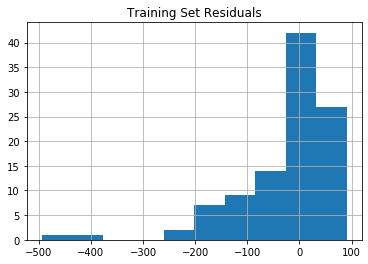

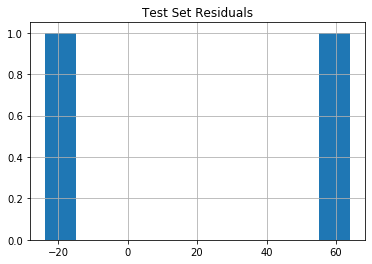

In [30]:
df_train_res = df17_merge[:103]
df_test_res = df17_merge[103:]
plt.figure(figsize=(8,5))
df_train_res.hist(column='residuals')
plt.title('Training Set Residuals')
df_test_res.hist(column='residuals')
plt.title('Test Set Residuals')
plt.show()

## Item 130173 will now be fitted using Prophet

In [31]:
df130173 = df[['ds','130173']]

df130173 = df130173.rename({'130173': 'y'}, axis=1)
print(df17)

            ds           y
0   2018-07-01  164.285714
1   2018-07-08  400.000000
2   2018-07-15  127.777778
3   2018-07-22  157.894737
4   2018-07-29  191.304348
..         ...         ...
100 2020-05-31  176.923077
101 2020-06-07  233.333333
102 2020-06-14  338.888889
103 2020-06-21  188.235294
104 2020-06-28  100.000000

[105 rows x 2 columns]


104  WEEKS


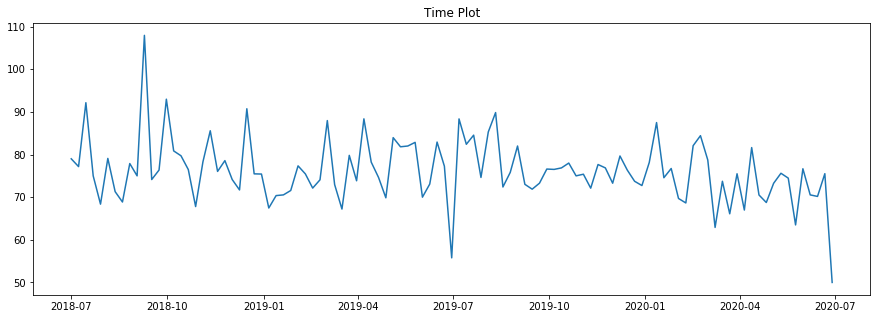

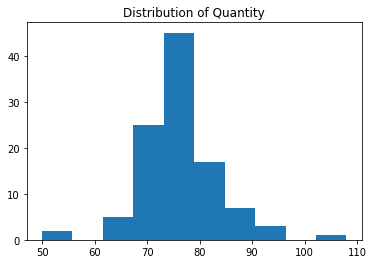

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 CALCULATE FORECAST
            ds       yhat  yhat_lower  yhat_upper
102 2020-06-14  73.736156   65.509291   82.208062
103 2020-06-21  73.682172   64.293847   83.376050
104 2020-06-28  73.628188   64.967287   83.247598
105 2020-07-05  73.574203   64.698025   82.160141
106 2020-07-12  73.520219   64.958170   82.781125

 PLOT OF TRAINING SET, TEST SET, FORECAST


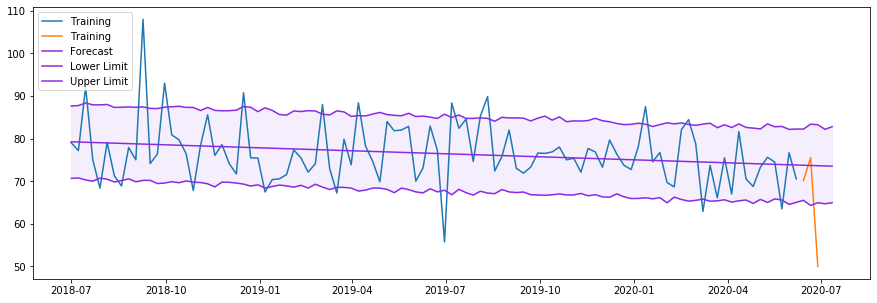


 RESULTS PLOT


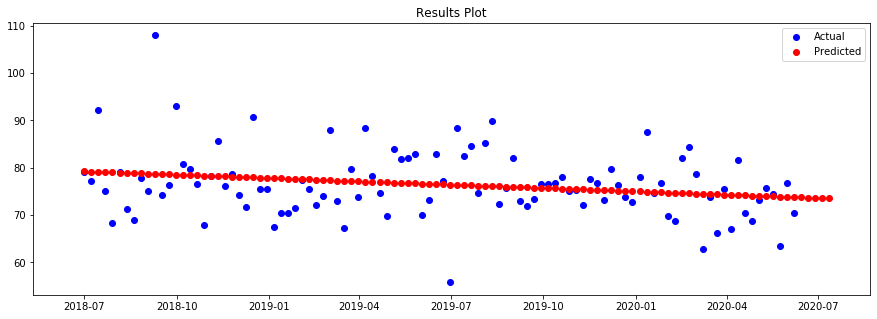


 COMPONENTS PLOT


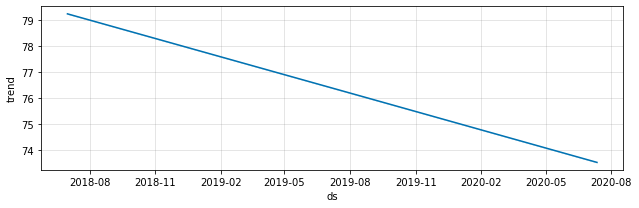

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-05-24 00:00:00 and 2020-05-24 00:00:00



 EVALUATE FORECAST USING CROSS VALIDATION
          ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2020-05-31  73.912379   65.050995   83.020170  76.666667 2020-05-24
1 2020-06-07  73.859865   64.326897   82.329882  70.535714 2020-05-24

 PERFORMANCE METRICS
  horizon        mse      rmse       mae      mape     mdape  coverage
0  7 days   7.586099  2.754287  2.754287  0.035925  0.035925       1.0
1 14 days  11.049981  3.324151  3.324151  0.047127  0.047127       1.0

 CROSS VALIDATION METRIC: MAPE


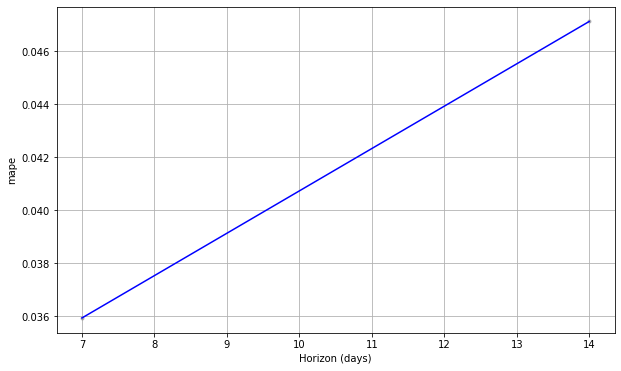


 CROSS VALIDATION METRIC: RMSE


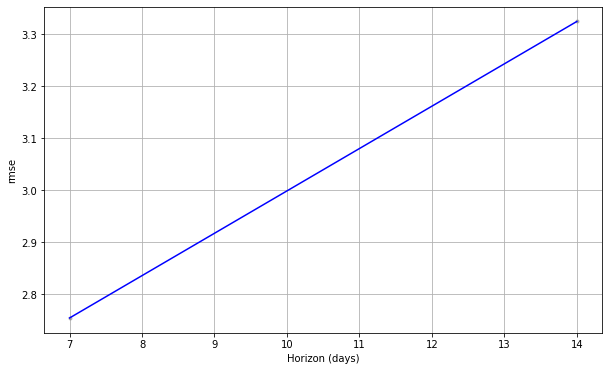


 R^2_score
-0.5860894585848573

 MAE: 9.672312

 CALCULATE AND PLOT RESIDUALS


<Figure size 576x360 with 0 Axes>

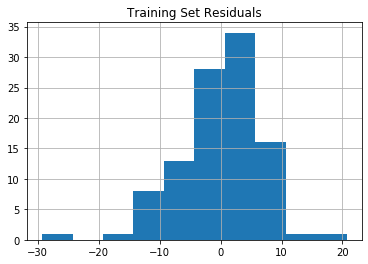

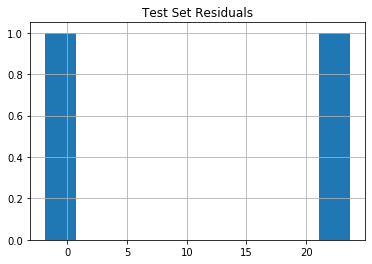

In [32]:
dfx = df130173
#calculate number of weeks in data set
start_date = min(dfx['ds'])
end_date = max(dfx['ds'])
days = pd.to_datetime(end_date) - pd.to_datetime(start_date)
week = int(pd.Timedelta(days).days / 7)
print(week, color.BOLD + ' WEEKS' + color.END)
    
    
#Create Time-Plot of data
plt.figure(figsize=(15,5))
plt.plot(dfx['ds'],dfx['y'])
plt.title('Time Plot')
plt.show()
    
#Create Distribution of Quantity
plt.hist(dfx['y'])
plt.title('Distribution of Quantity')
plt.show()
    
#Train-Test-Split
y_train, y_test = train_test_split(dfx, train_size=train_len)
    
#Fit Model
m = Prophet()
m.fit(y_train)
    
#Calculate forecast
print('\n', color.BOLD + 'CALCULATE FORECAST' + color.END)
future = m.make_future_dataframe(periods=5, freq='W')
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
    
#get data ready to plot forecast
df_ds_index = dfx.set_index('ds')
y_train_ds_index = y_train.set_index('ds')
y_test_ds_index = y_test.set_index('ds')
forecast_ds_index = forecast.set_index('ds')

#Plot training, test, forecast
print('\n', color.BOLD + 'PLOT OF TRAINING SET, TEST SET, FORECAST' + color.END)
#Plot training, test, forecast
#https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5

plt.figure(figsize=(15,5))
plt.plot(y_train_ds_index,label='Training')
plt.plot(y_test_ds_index,label='Training')
plt.plot(forecast_ds_index['yhat'],label='Forecast',color='blueviolet')
plt.plot(forecast_ds_index['yhat_lower'],label='Lower Limit', color='blueviolet')
plt.plot(forecast_ds_index['yhat_upper'],label='Upper Limit', color='blueviolet')
plt.fill_between(forecast.ds, forecast['yhat_lower'], forecast['yhat_upper'],color='blueviolet', alpha=0.08)
plt.legend(loc='upper left')
plt.show()

    
# Plot the results
print('\n', color.BOLD + 'RESULTS PLOT' + color.END)
plt.figure(figsize=(15,5))
label=['Actual','Predicted']
plt.scatter(x=y_train['ds'], y=y_train['y'],c='blue', label = 'Actual')
plt.scatter(x=forecast['ds'], y=forecast['yhat'], c='red', label = 'Predicted')
plt.title('Results Plot')
plt.legend(label)
plt.show()

#Plot Components
print('\n', color.BOLD + 'COMPONENTS PLOT' + color.END)
fig2 = m.plot_components(forecast)
plt.show()
    
#Evaluate forecast using cross validation
# https://futurice.com/blog/business-forecasting-with-facebook-prophet
#Training data (initial): The amount of data set aside for training. The parameter is in the API called initial.
#Horizon: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2.
#Cutoff (period): a forecast is made for every observed point between cutoff and cutoff + horizon.
    
print('\n', color.BOLD + 'EVALUATE FORECAST USING CROSS VALIDATION' + color.END)
df_cv = cross_validation(m, initial= '99 W', period='1 W', horizon = '2 W')
print(df_cv.head())
    
# https://futurice.com/blog/business-forecasting-with-facebook-prophet
print('\n', color.BOLD + 'PERFORMANCE METRICS' + color.END)
df_p = performance_metrics(df_cv)
print(df_p.head())
    
#https://futurice.com/blog/business-forecasting-with-facebook-prophet
#mape = mean absolute percentage error 
print('\n', color.BOLD + 'CROSS VALIDATION METRIC: MAPE' + color.END)
plot_cross_validation_metric(df_cv, metric='mape')
plt.show()
    
#rmse is mean squared error
print('\n', color.BOLD + 'CROSS VALIDATION METRIC: RMSE' + color.END)
plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

#find r squared and mean absolute error
from sklearn.metrics import r2_score
r2 = r2_score(y_test.y,forecast.yhat[102:105])
print('\n', color.BOLD + "R^2_score"+ color.END)
print(r2)
from sklearn.metrics import mean_absolute_error
mae2 = mean_absolute_error(y_test.y,forecast.yhat[102:105])
print('\n', color.BOLD + 'MAE: %f' % mae2 + color.END)
    
#https://github.com/facebook/prophet/issues/309
df_merge = pd.merge(dfx, forecast, on='ds')
#print(df_merge.head())
    
#Calculate and Plot Residuals    
print('\n', color.BOLD + 'CALCULATE AND PLOT RESIDUALS' + color.END)
df_merge['residuals'] = df_merge['yhat'] - df_merge['y']
#print(df_merge)
    
df_train_res = df_merge[:103]
df_test_res = df_merge[103:]
plt.figure(figsize=(8,5))
df_train_res.hist(column='residuals')
plt.title('Training Set Residuals')
df_test_res.hist(column='residuals')
plt.title('Test Set Residuals')
plt.show()